# Australia Water Quality Monitoring Dataset
This notebook is working on the data of water quality measurements for Brisbane River, Australia. The goal of this notebook is to do exploratory data analysis (EDA) and therefore to generate the big picture description about Brisbane River's water and interesting insights of the data.

*Source*: [Queensland Government Open Data Portal](https://www.data.qld.gov.au/dataset/brisbane-river-colmslie-site-water-quality-monitoring-buoy/resource/0ec4dacc-8e78-4c2a-aa70-d7865ec098e2), as quoted by: [Daniel Fedorov](https://www.kaggle.com/downshift) in [Kaggle: Water Quality Monitoring Dataset](https://www.kaggle.com/datasets/downshift/water-quality-monitoring-dataset)

### Step 1: Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import warnings

### Step 2: Read the CSV File and Import the Data as a Pandas Dataframe

In [2]:
df = pd.read_csv('/home/jasonzelin/data-analytics-portfolio/australia_water_quality_monitoring/data/brisbane_water_quality.csv')

### Step 3: Start the Exploratory Data Analysis (EDA)

Identify the shape and data types of each column existing in the dataframe

In [ ]:
print("The shape of the data is ", df.shape)
print("The data types of each column are as below: df.dtypes)

The shape of the data is  (30894, 20)
The data types of each column are as below:
 Timestamp                                    object
Record number                                 int64
Average Water Speed                         float64
Average Water Direction                     float64
Chlorophyll                                 float64
Chlorophyll [quality]                       float64
Temperature                                 float64
Temperature [quality]                       float64
Dissolved Oxygen                            float64
Dissolved Oxygen [quality]                  float64
Dissolved Oxygen (%Saturation)              float64
Dissolved Oxygen (%Saturation) [quality]    float64
pH                                          float64
pH [quality]                                float64
Salinity                                    float64
Salinity [quality]                          float64
Specific Conductance                        float64
Specific Conductance [quality]   

Convert column **'Timestamp'** to pandas readable **timestamp** format & dropping column 'Record number' and columns with tag '[quality]', since those columns have no significance to the analysis

In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.drop(columns='Record number', inplace=True)

regexp = re.compile(pattern=r'.*(\[quality\])$')
original_column_names = df.columns
filtered_column_names = [n for n in original_column_names if not(regexp.match(n))]
df = df[filtered_column_names]

Check for missing values and fil it with median

In [ ]:
print("Missing values: df.isnull().sum()/df.shape[0])

Missing values:
 Timestamp                         0.000000
Average Water Speed               0.000647
Average Water Direction           0.000032
Chlorophyll                       0.018936
Temperature                       0.167152
Dissolved Oxygen                  0.139186
Dissolved Oxygen (%Saturation)    0.186088
pH                                0.035088
Salinity                          0.128115
Specific Conductance              0.044248
Turbidity                         0.064737
dtype: float64


In [6]:
for i in filtered_column_names:
    column_median = df[i].median()
    df[i] = df[i].fillna(value=column_median)

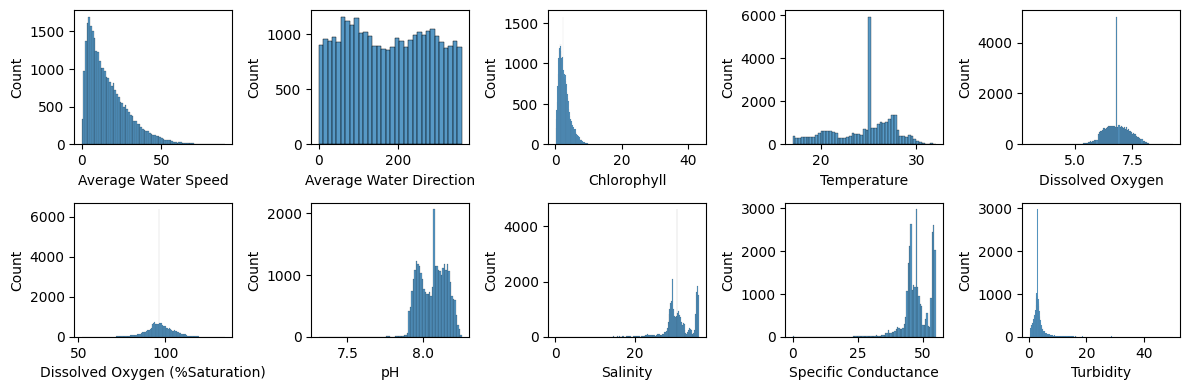

In [7]:
# Creating distribution plots
numeric_datetime_columns = df.select_dtypes(include=["number"]).columns.tolist()

# Create subplots: 4 row, 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
r = 0
c = 0
for i in numeric_datetime_columns:
    sns.histplot(data=df, x=i, ax=axes[r, c])
    if (c + 1) % 5 == 0:
        r = r + 1
        c = 0
    else:
        c = c + 1

plt.tight_layout()
plt.show()

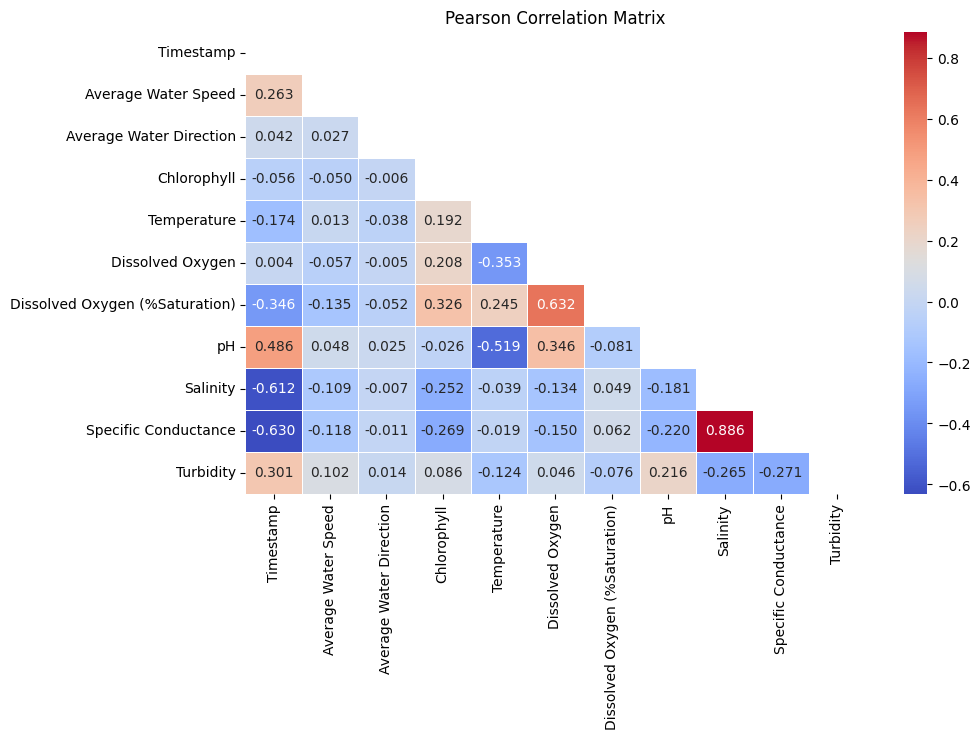

In [8]:
correlation_matrix = df.corr(method='pearson')
correlation_matrix = correlation_matrix.round(3)
masking_matrix = np.triu(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=masking_matrix)
plt.title('Pearson Correlation Matrix')
plt.show()

Several insights can be derived from the correlation plot above. Salinity positively correlates to specific conductance with 1 coefficient of correlation. Therefore, specific conductance will be removed from the analysis, as it can be simply represented by salinity. A few metrics that high correlation with time (both positive and negative) are **salinity** and **pH**. Other interesting correlations are as follows: 
- pH vs Temperature
- pH vs Dissolved Oxygen
- Dissolved Oxygen vs Temperature.

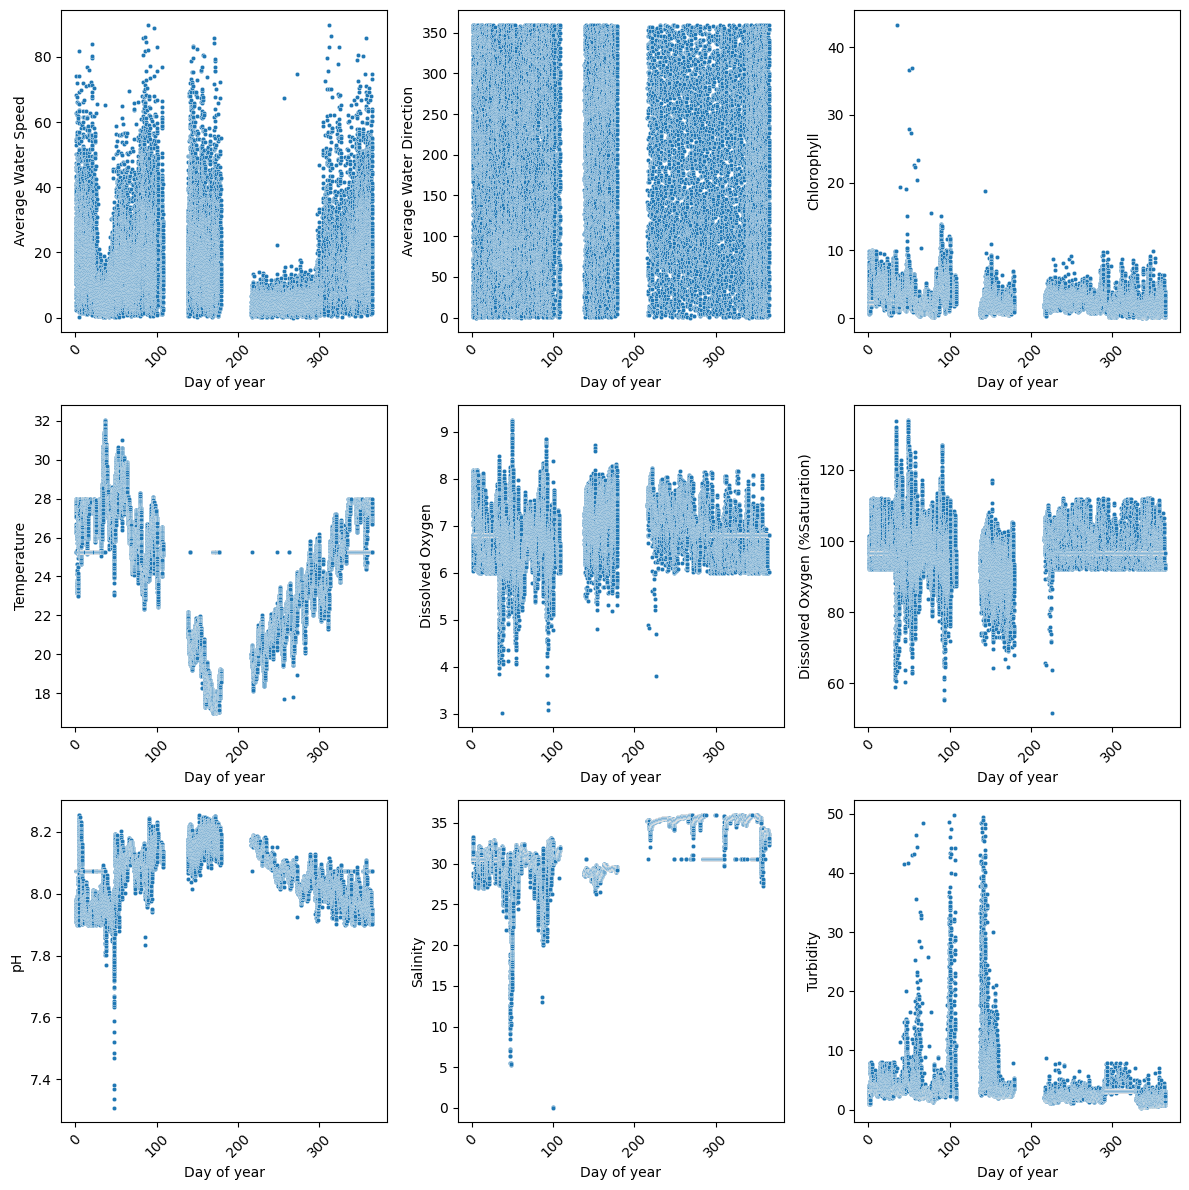

In [9]:
# Creating time series line plot
filtered_column_names.remove("Timestamp")
filtered_column_names.remove("Specific Conductance")
df['Day of year'] = df['Timestamp'].dt.dayofyear

# Create subplots: 4 row, 5 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
r = 0
c = 0
for i in filtered_column_names:
    sns.scatterplot(data=df, x='Day of year', y=i, ax=axes[r, c], s=10)
    if (c + 1) % 3 == 0:
        r = r + 1
        c = 0
    else:
        c = c + 1

# Rotate date labels on all plots
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As it can be observed from the scatter plots above and supported by the aforementioned insights in the correlation plot, pH and salinity has a positive trend. However, it can be more clearly identified from the time series scatter plot that both **pH** and **salinity** has an inclining overall trend due to the extreme lows in around the 50th day of year (February). On the other hand, **temperature** and **turbidity** have a visible pattern with the resemblance of parabolic curves.

### Step 4: Make a model to predict & fine tune the model

After the observation from EDA (step 3), I decided to make predictions of the variable temperature using a parabolic (polynomial) model.

In [ ]:
X = df[['Day of year']]
y = df['Temperature']

# Fit polynomial regression of degree 3
warnings.filterwarnings("ignore")
model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

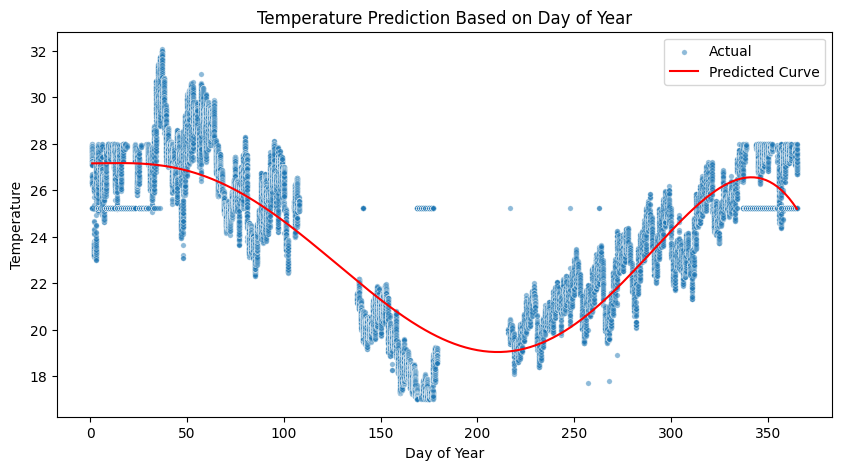

In [35]:
days = np.arange(1, 366).reshape(-1,1)
predicted_temp = model.predict(days)

# Plot actual + predicted
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Day of year', y='Temperature', data=df, s=15, alpha=0.5, label="Actual")
plt.plot(days, predicted_temp, color='red', label="Predicted Curve")
plt.xlabel("Day of Year")
plt.ylabel("Temperature")
plt.legend()
plt.title("Temperature Prediction Based on Day of Year")
plt.show()

In a glance, the model fits quite well to the data visually. However, certain adjustments could do some fine tuning to the models and increase the accuracy. In this case, the polynomial degrees will be tha parameter for the fine tuning, whereas the accuracy will be measure using the mean absoulte errors of the predicted values.

In [30]:
days_list = []
for i in days:
    days_list.append(i[0])
    
df_p = pd.DataFrame(data={"Day of year": days_list, "Temperature_predicted": predicted_temp})
df_merge = df.merge(right=df_p, how='left', on='Day of year')
df_merge['Temperature_AE'] = abs(df_merge['Temperature'] - df_merge['Temperature_predicted']) ** 2 / df_merge['Temperature']
MAE = df_merge['Temperature_AE'].mean()
accuracy = 1 - df_merge['Temperature_AE'].mean()

print(f"The current mean absolute error is {MAE:.2%}. Hence the initial accuracy is {accuracy:.2%}")

The current mean absolute error is 10.69%. Hence the initial accuracy is 89.31%


In [33]:
deg = 2
counter = 0
max_iter = 10
deg_accur_dict = {}
while (accuracy < 0.95) & (counter < max_iter):
    init_accuracy = accuracy
    model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    model.fit(X, y)

    predicted_temp = model.predict(days)

    df_p = pd.DataFrame(data={"Day of year": days_list, "Temperature_predicted": predicted_temp})
    df_merge = df.merge(right=df_p, how='left', on='Day of year')
    df_merge['Temperature_AE'] = abs(df_merge['Temperature'] - df_merge['Temperature_predicted']) ** 2 / df_merge['Temperature']
    MAE = df_merge['Temperature_AE'].mean()
    accuracy = 1 - df_merge['Temperature_AE'].mean()
    deg_accur_dict[deg] = accuracy

    if accuracy >= init_accuracy:
        deg = deg + 1
    elif (accuracy < init_accuracy) & (deg - 1 > 1):
        deg = deg - 1
    else:
        deg = deg + 1
    print(f"Iteration #{counter+1}: Accuracy increased from {init_accuracy:.2%} to {accuracy:.2%} with polynomial degree of {deg}")
    counter = counter + 1

Iteration #1: Accuracy increased from 79.49% to 79.49% with polynomial degree of 3
Iteration #2: Accuracy increased from 79.49% to 82.15% with polynomial degree of 4
Iteration #3: Accuracy increased from 82.15% to 89.31% with polynomial degree of 5
Iteration #4: Accuracy increased from 89.31% to 87.39% with polynomial degree of 4
Iteration #5: Accuracy increased from 87.39% to 89.31% with polynomial degree of 5
Iteration #6: Accuracy increased from 89.31% to 87.39% with polynomial degree of 4
Iteration #7: Accuracy increased from 87.39% to 89.31% with polynomial degree of 5
Iteration #8: Accuracy increased from 89.31% to 87.39% with polynomial degree of 4
Iteration #9: Accuracy increased from 87.39% to 89.31% with polynomial degree of 5
Iteration #10: Accuracy increased from 89.31% to 87.39% with polynomial degree of 4


### Insights & Thoughts on the Data of Brisbane's Water Quality

1. The variable temperature, pH and salinity are the ones that have visible trends over time.
2. Salinity correlates proportionately to the specific conductance of the water.
3. The trend of temperature may be predicted using polynomial model with polynomial degree of 5, resulting in roughly 89% accuracy.

### Caveats:
The data is only available for a year of timeframe. It could pretty much take into account the factor of seasonalities in an annual cycle. However, more data points from more years could be a potential aid for higher level of confidence.